# TFLiteDemo

This notebook is used for training and export a TFLite model to use in building an android app.

In [ ]:
!git clone https://github.com/baobuiquang/datasets.git &> /dev/null
!cp /content/datasets/mnist_png.zip /content           &> /dev/null
!unzip /content/mnist_png.zip                          &> /dev/null

## Training TF model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
img_height, img_width = 28, 28
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/mnist_png/train",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    validation_split = 0.2,
    seed = 100,
    subset = "training",
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/mnist_png/train",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    validation_split = 0.2,
    seed = 100,
    subset = "validation",
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/mnist_png/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 120000 files belonging to 10 classes.
Using 96000 files for training.
Found 120000 files belonging to 10 classes.
Using 24000 files for validation.
Found 20000 files belonging to 10 classes.


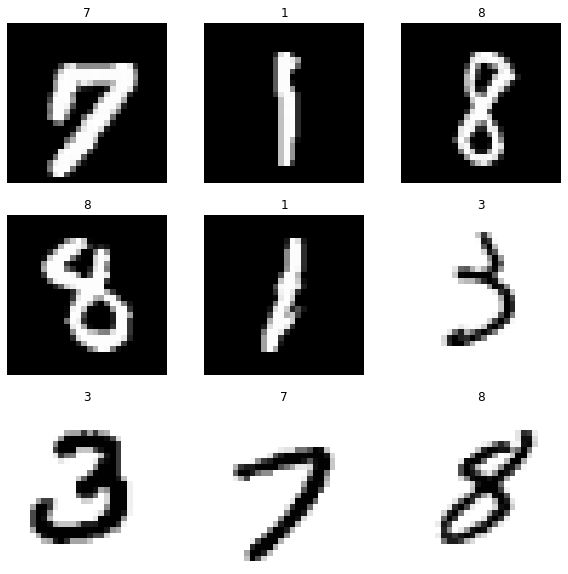

In [ ]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Input(shape=(28,28,3)),
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(10)
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          9

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3,
)

Epoch 1/3
4800/4800 [==============================] - 171s 35ms/step - loss: 0.2418 - accuracy: 0.9222 - val_loss: 0.1016 - val_accuracy: 0.9677
Epoch 2/3
4800/4800 [==============================] - 187s 39ms/step - loss: 0.1011 - accuracy: 0.9681 - val_loss: 0.0869 - val_accuracy: 0.9725
Epoch 3/3
4800/4800 [==============================] - 167s 35ms/step - loss: 0.0772 - accuracy: 0.9758 - val_loss: 0.0826 - val_accuracy: 0.9743


In [ ]:
model.evaluate(test_ds)

1000/1000 [==============================] - 15s 15ms/step - loss: 0.0818 - accuracy: 0.9751


[0.08175311982631683, 0.9750999808311462]

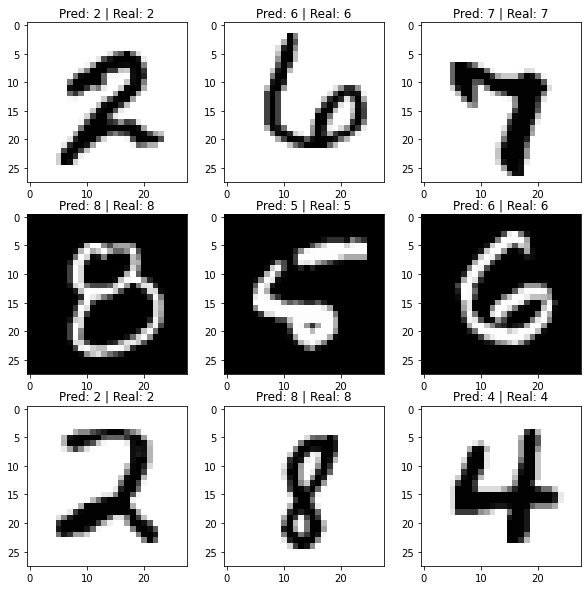

In [ ]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

## Export TFLite model

Convert TF model to TFLite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)